## Machine learning guided search for high strength high entropy refractory alloys
## Ramsey Issa and Trupti Mohanty 
## CS6350 Project 

## This notebook is for data preprocessing, atom% featurizer and ml models training/evaluation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport
from cbfv.composition import generate_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
rng_seed = 20
%matplotlib inline
import warnings 
import warnings
warnings.filterwarnings("ignore")



### Loading the mpea dataset consists of 27 columns (major features are formula, phases, density, synthesis method,temp, YS,UTS,datareference)


In [2]:
df = pd.read_csv('data/combined_data.csv')
df.shape

(1545, 27)

In [3]:
df.columns 

Index(['Unnamed: 0', 'REFERENCE: tag', 'REFERENCE: doi', 'FORMULA',
       'PROPERTY: Type of phases', 'PROPERTY: Single/Multiphase',
       'PROPERTY: synthesis method', 'PROPERTY: grain size ($\mu$m)',
       'PROPERTY: ROM Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)', 'PROPERTY: ROM Young modulus (GPa)',
       'PROPERTY: Exp. Young modulus (GPa)', 'PROPERTY: O content (wppm)',
       'PROPERTY: N content (wppm)', 'PROPERTY: C content (wppm)',
       'REFERENCE: comment', 'Internal Reference #', 'Original DOI',
       'PROPERTY: Exp. Density (g/cm$^3$)', 'Unnamed: 22',
       'IDENTIFIER: Reference ID'],
      dtype='object')

In [4]:
# considering formula,property, test temp , YS 
df1 = df[['FORMULA','PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)']].copy(deep=True)
df1.columns = ['formula','T','target']
df1.shape

(1545, 3)

In [5]:
# drop the rows which are having nan value 
df2=df1.dropna()
df2=df2.reset_index(drop=True)
print('after dropping nan value shape:',df2.shape)


after dropping nan value shape: (1067, 3)


In [6]:
df2['target'] = [s.split()[0] for s in df2['target']]  ####### as some of the YS values contain string for example 991 $\pm$ 8
df2['target'] = df2['target'].astype(float) ## setting the YS value to float

In [7]:
print(df2.describe())

                 T       target
count  1067.000000  1067.000000
mean    257.693346   889.961471
std     407.670494   570.135437
min    -268.800000    24.000000
25%      25.000000   408.000000
50%      25.000000   822.000000
75%     600.000000  1260.000000
max    1600.000000  3416.000000


 25.0      682
 1000.0     80
 800.0      61
 1200.0     55
 600.0      47
 23.0       28
 700.0      16
 400.0      15
 20.0       11
-196.0       9
 200.0       8
 100.0       6
 300.0       6
 900.0       5
 1400.0      4
-268.8       4
-70.0        4
-43.0        3
-192.0       3
-153.0       3
-103.0       3
 72.0        3
 1600.0      2
 1100.0      2
 60.0        2
 500.0       2
 650.0       1
-73.0        1
 24.0        1
Name: T, dtype: int64

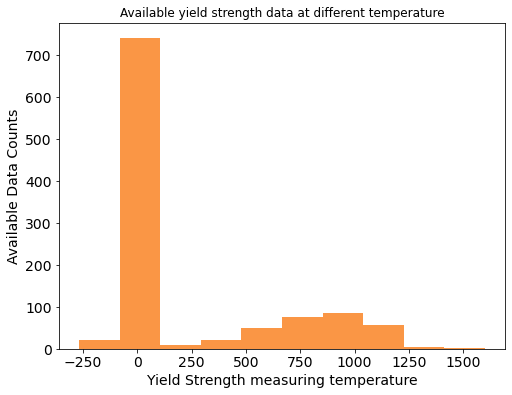

In [8]:
# df_test = pd.DataFrame([df2['T'].value_counts().index,df2['T'].value_counts().reset_index(drop=True)]).T 
# df_test.columns = ['T','counts']
# df_test = df_test.sort_values(by='T')
# plt.figure(figsize=(13,6))
# plt.bar(df_test['T'], df_test['counts'])
# plt.hist(df_test['T'])


plt.figure(figsize=(8,6))
df2['T'].hist(alpha = 0.75,facecolor = '#F97306',grid=False)

plt.ylabel('Available Data Counts', fontsize=14 )
plt.xlabel('Yield Strength measuring temperature',fontsize=14)
plt.tick_params(labelsize=14)
plt.title('Available yield strength data at different temperature')
df2['T'].value_counts() # to check the data availability around room temperature


(722, 3)
unique formula 418


1100.0

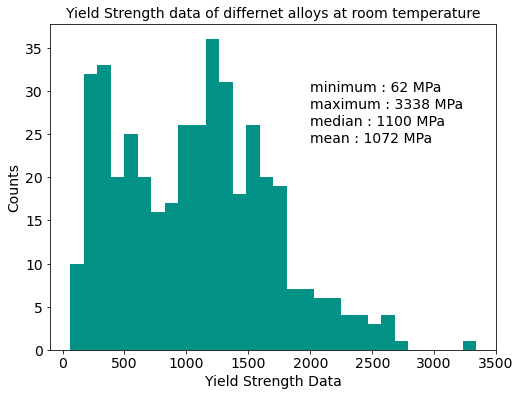

In [9]:
df_temp_25 = df2.loc[[i in [20,23,24,25] for i in df2['T']],]
print(df_temp_25.shape)
print('unique formula',len(df_temp_25['formula'].unique()))
df_YS = df_temp_25.groupby('formula', as_index=False).min() # considering min 
df_YS.shape

plt.figure(figsize=(8,6))
df_YS['target'].hist(alpha = 1,facecolor = '#029386',grid=False,bins=30)
plt.ylabel('Counts', fontsize=14 )
plt.xlabel('Yield Strength Data',fontsize=14)
plt.tick_params(labelsize=14)
plt.annotate('minimum : 62 MPa',(2000,30),fontsize=14)
plt.annotate('maximum : 3338 MPa',(2000,28),fontsize=14)
plt.annotate('median : 1100 MPa',(2000,26),fontsize=14)
plt.annotate('mean : 1072 MPa',(2000,24),fontsize=14)
plt.title('Yield Strength data of differnet alloys at room temperature',fontsize=14)

np.median(df_YS['target'])

# df_YS['target'].describe()

{'whiskers': [<matplotlib.lines.Line2D at 0x114ee9af0>,
 'caps': [<matplotlib.lines.Line2D at 0x114ee97c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x114ee9400>],
 'medians': [<matplotlib.lines.Line2D at 0x114ef8820>],
 'fliers': [<matplotlib.lines.Line2D at 0x114ef8bb0>],
 'means': []}

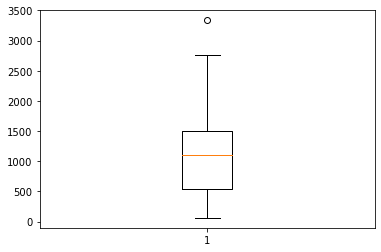

In [10]:
plt.boxplot(df_YS['target'])

In [11]:
df_YS = df_YS.drop(columns=['T'])
df_YS.shape
df_YS.to_csv('data/cleaned_ys.csv',index = False)

## Representing the formula as atom percentage as one of the featurization scheme

In [12]:
from cbfv.composition import _fractional_composition as fract
df_frac = pd.DataFrame([fract(comp) for comp in df_YS['formula']])

df_frac = df_frac.fillna(0)
print(df_frac.head(5))


         Al        Fe        Co        Ni         C        Cr        Cu  \
0  0.185948  0.341905  0.235935  0.235935  0.000277  0.000000  0.000000   
1  0.000000  0.192661  0.192661  0.192661  0.000000  0.192661  0.192661   
2  0.000000  0.194690  0.194690  0.194690  0.000000  0.194690  0.194690   
3  0.000000  0.196581  0.196581  0.196581  0.000000  0.196581  0.196581   
4  0.000000  0.198347  0.198347  0.198347  0.000000  0.198347  0.198347   

          V   Mn   Mo  ...   Hf   Li   Mg   Ca   Si    Y    W   Pd   Re   Sc  
0  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.036697  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.026549  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.017094  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.008264  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 26 columns]


(26, 2)

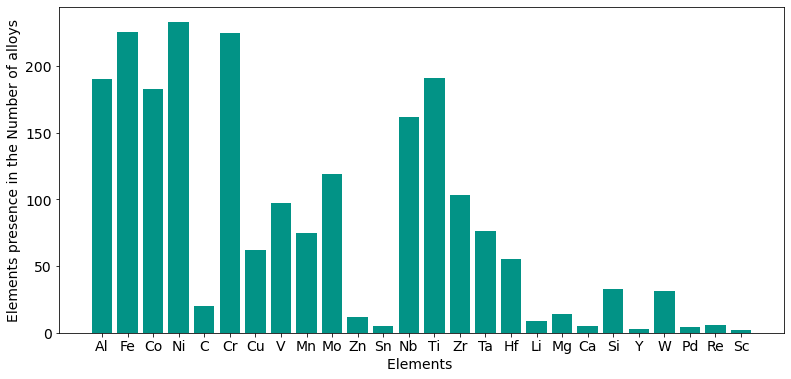

In [13]:
## Plot To show what are the elements and their presence in number of alloys 
plt.figure(figsize=(13,6))
df_ele = pd.DataFrame([[c,(df_frac[c] !=0.0 ).sum()] for c in df_frac.columns ])

df_ele.columns = ['element','counts']
plt.bar(df_ele['element'][0:26],df_ele['counts'][0:26],color = '#029386')
plt.xlabel('Elements ',size = 14)
plt.ylabel('Elements presence in the Number of alloys',size = 14)
plt.tick_params(labelsize=14)
df_ele.shape


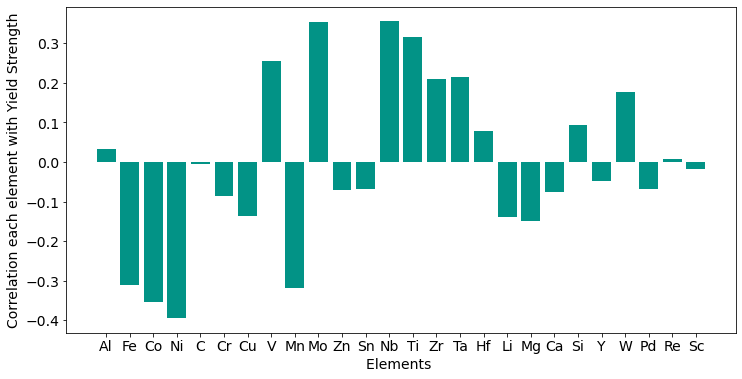

In [14]:
df_frac['target'] = df_YS['target']
#print(df_frac.describe())
df_corr = df_frac.corr()
plt.figure(figsize=(12,6))
plt.bar(df_corr.index[0:26],df_corr['target'][0:26],color = '#029386')
plt.xlabel('Elements ',size = 14)
plt.ylabel('Correlation each element with Yield Strength',size = 14)
plt.tick_params(labelsize=14)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
#df_frac.corr()
# sns.heatmap(df_frac.corr(),cmap="crest")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

## Split the data into train/test split

In [16]:
df_train,df_test = train_test_split(df_frac, test_size=0.2, random_state=rng_seed)
df_train.shape

(334, 27)

## Separating X_train/y_train, X_test/y_test

In [17]:
X_train_unscaled = df_train.loc[:, df_train.columns != 'target']
y_train = df_train['target']
X_test_unscaled = df_test.loc[:, df_test.columns != 'target']
y_test = df_test['target']
X_train_unscaled.iloc[0]
y_train

361    1525.0
390    1883.0
81     1465.0
45     2350.0
389    1826.0
        ...  
218     620.0
412     793.0
223     403.0
271    2034.0
355    1211.0
Name: target, Length: 334, dtype: float64

## Scaling 

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled)
X_test_scaled = scaler.transform(X_test_unscaled)


In [19]:
print('size of train data', len(df_train))
print('size of test data',len(df_test))


size of train data 334
size of test data 84


## Helper function to plot and performance calcualtion

In [20]:

################# EVALUATION MATRIX #######################################
def model_evaluation(y_actual,y_predict, label = None,model='None'):
    df = pd.DataFrame([{'mae':mean_absolute_error(y_actual,y_predict),
                        'rmse':mean_squared_error(y_actual,y_predict,squared=False),
                        'r2score':r2_score(y_actual,y_predict),
                        'model':model
                        }])
    if label:
        df.index = [label]
        
    return df

def model_evaluation_result(y_Train,y_train_predict,y_Test,y_test_predict,model='None'):
    result = pd.concat([model_evaluation(y_Train,y_train_predict,'Train',model),
                    model_evaluation(y_Test,y_test_predict, 'Test',model)])
    return result


def plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0,r2_test=0):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train,y_train_predict, s=160,alpha=0.7, color = '#029386',label='Training Data ($r^2$ ={0:.3f})'.format(r2_train))
    plt.scatter(y_test,y_test_predict,s=160, alpha=0.7, color = '#F97306',label='Test Data ($r^2$ ={0:.3f})'.format(r2_test))
    # plt.plot(y_test,y_test,'--',dashes=(5, 6),linewidth=2,c='grey',label = 'Ideal Fit')
    plt.axline((0, 0), (3600, 3600), linewidth=2, color='k',linestyle='dashed',label='ideal fit')
    plt.xlabel('Actual Yield Strength (MPa) ', size=16)
    plt.ylabel('Predicted Yield Strength (MPa)',size=16)
    plt.tick_params(labelsize=14)
    # plt.xlim((0,1200))
    # plt.ylim((0,1200))
    plt.legend(prop={'size': 14})
    plt.minorticks_on()
    plt.tick_params(labelsize=16)
    plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
    plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')



## Gradient Boost Regressor CV

In [21]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingRegressor(random_state=rng_seed, criterion='squared_error')


param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3,4,5,6,7],
                'max_features': [1, 'sqrt', 'log2'],
                'min_samples_split': [4,5,6,7],
                'min_samples_leaf':[3,4,5,6],
             }



gbr_gs= GridSearchCV(
                     base_model,
                     param_grid,
                     scoring='neg_mean_squared_error',
                     cv=5
                    )

# Fit training Data 
gbr_gs.fit(X_train_scaled,y_train)

# Best Estimator
print(gbr_gs.best_estimator_)

gbr_gs_best=gbr_gs.best_estimator_


gbr_gs_best.fit(X_train_scaled,y_train)

# predict y_train and y_test
y_train_predict=gbr_gs_best.predict(X_train_scaled)
y_test_predict=gbr_gs_best.predict(X_test_scaled)


print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='GBR CV'))


GradientBoostingRegressor(criterion='squared_error', max_depth=7,
                          max_features='sqrt', min_samples_leaf=5,
                          min_samples_split=4, n_estimators=200,
                          random_state=20)
              mae        rmse   r2score   model
Train   60.435708   88.454888  0.979060  GBR CV
Test   243.616775  381.801328  0.607825  GBR CV


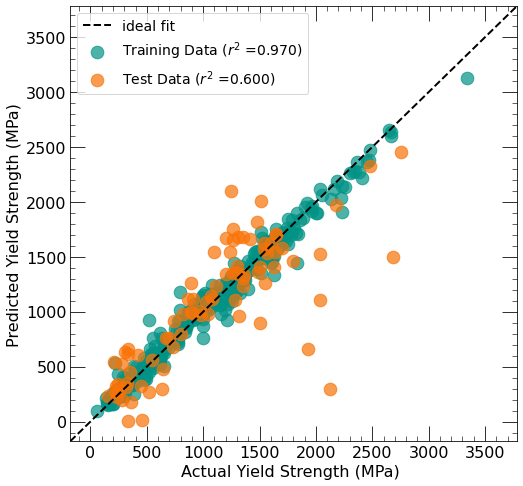

In [22]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.97,r2_test=0.60)

## Random Forest Regressor CV 

In [23]:
##### Random forest regressor with Grid search ############################
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
base_model = RandomForestRegressor(random_state=rng_seed, criterion='mse')

param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3,4,5,6,7],
                'max_features': [1, 'sqrt', 'log2'],
                'min_samples_split': [4,5,6,7],
                'min_samples_leaf':[3,4,5,6],
             }

rf_gs=GridSearchCV(base_model,param_grid,scoring='neg_mean_squared_error',cv=5)
rf_gs.fit(X_train_scaled,y_train)
print(rf_gs.best_estimator_)


rf_best = rf_gs.best_estimator_
print(rf_best)


y_train_predict=rf_best.predict(X_train_scaled)
y_test_predict=rf_best.predict(X_test_scaled)

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='RF CV'))
# plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0,r2_test=0)



RandomForestRegressor(criterion='mse', max_depth=7, max_features='sqrt',
                      min_samples_leaf=3, min_samples_split=7, random_state=20)
RandomForestRegressor(criterion='mse', max_depth=7, max_features='sqrt',
                      min_samples_leaf=3, min_samples_split=7, random_state=20)
              mae        rmse   r2score  model
Train  250.838037  336.323322  0.697273  RF CV
Test   286.649127  412.752768  0.541663  RF CV


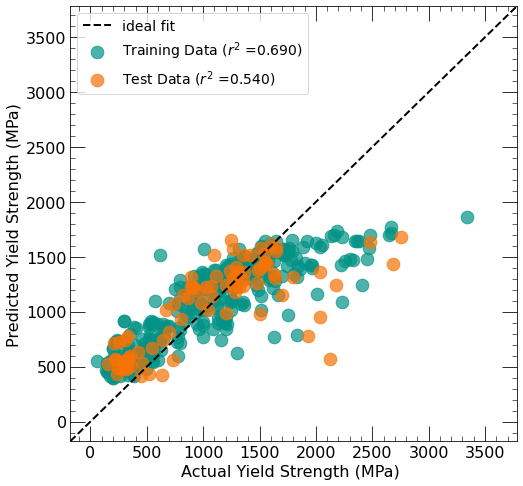

In [24]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.69,r2_test=0.54)

## SVR CV

In [25]:
## SVR 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr_params = {
    'C': [1,10,100,1000],
    "kernel":['linear','poly','rbf','sigmoid'],
    "epsilon":[0.001,0.01,0.1,1,10,100]
}


base_model = SVR(gamma='scale')



svr_gr=GridSearchCV(base_model,svr_params,scoring='neg_mean_squared_error',cv=5)



svr_gr.fit(X_train_scaled, y_train)

print(svr_gr.best_params_)
print("MSE:"+ str(-svr_gr.best_score_))

svr_best = svr_gr.best_estimator_
y_train_predict=svr_best.predict(X_train_scaled)
y_test_predict=svr_best.predict(X_test_scaled)

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='svr cv')) 



{'C': 1000, 'epsilon': 1, 'kernel': 'rbf'}
MSE:145398.324449868
              mae        rmse   r2score   model
Train  177.763475  324.500083  0.718184  svr cv
Test   257.460372  402.672041  0.563777  svr cv


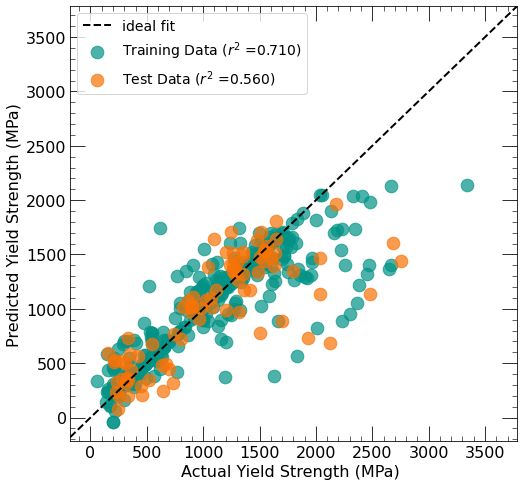

In [26]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.71,r2_test=0.56)

## KNN  with CV

In [27]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

KNN_params = {
    'n_neighbors': np.arange(2,12)
}

base_model = KNeighborsRegressor()


KNN_gr = GridSearchCV(base_model,KNN_params,scoring='neg_mean_squared_error',cv=5)

KNN_gr.fit(X_train_scaled, y_train)

print(KNN_gr.best_params_)
#print(KNN_gr.cv_results_)

KNN_best = KNN_gr.best_estimator_

y_train_predict=KNN_best.predict(X_train_scaled)
y_test_predict=KNN_best.predict(X_test_scaled)
print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,model='knn cv')) 





{'n_neighbors': 2}
              mae        rmse   r2score   model
Train  126.175659  194.036665  0.899236  knn cv
Test   296.104167  463.191506  0.422800  knn cv


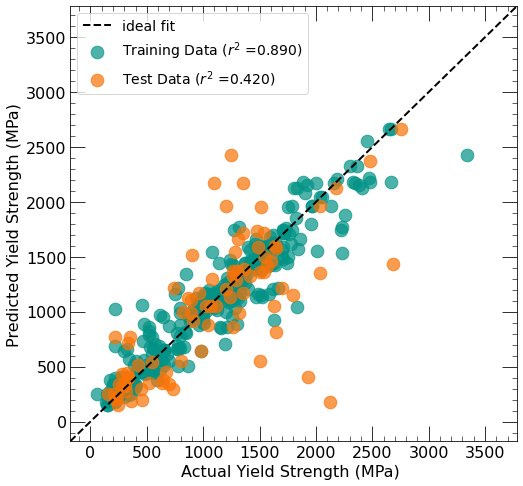

In [28]:
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train=0.89,r2_test=0.42)


## Bootstrap Estimator 

In [29]:
def bootstrap_estimator(model, X_train, y_train, X_test, n_iter=1000):
    
    '''
    Function to estimate the mean and standard deviation
    
    '''

    
    bootstrap_preds = np.zeros([len(X_test), n_iter])
    
    index = np.arange(X_train.shape[0])
    
    ## set the seed to repeat the boot strapping 
    np.random.seed(20)
    for i in range(n_iter):
        #sample from X_train, y_train
        index_sampled = np.random.choice(index, size=X_train.shape[0], replace=True)

        X_train_sample = X_train[index_sampled,:]
        y_train_sample = y_train[index_sampled]
        
        #model.fit(X_train_sample, y_train_sample)
        model.fit(X_train_sample, y_train_sample)
        
        #pred_i = model.predict(X_test)
        
        pred_i = model.predict(X_test)
        #print('pred_i:', pred_i)
        
        bootstrap_preds[:,i] = pred_i
        #print(bootstrap_preds)
        
    return(bootstrap_preds.mean(1),bootstrap_preds.std(1))

In [30]:
y_train = y_train.reset_index(drop = True)
mean_test , std_test  = bootstrap_estimator(gbr_gs_best, X_train_scaled, y_train, X_test_scaled, n_iter=1000)


# print(pd.DataFrame([mean_test,std_test]))

mean_train , std_train  = bootstrap_estimator(gbr_gs_best, X_train_scaled, y_train, X_train_scaled, n_iter=1000)


## Mean and Standard Deviation for Test data 

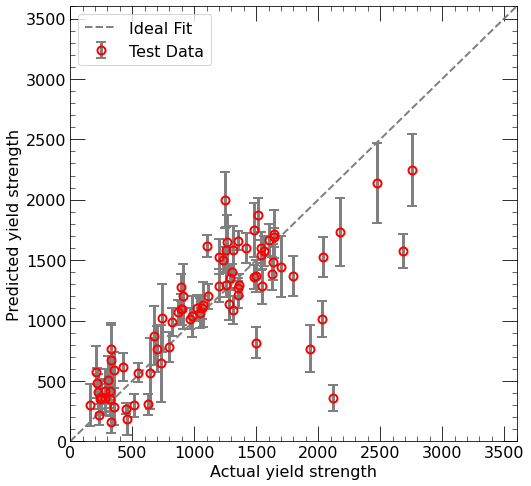

In [31]:
plt.figure(figsize=(8,8))

plt.errorbar(y_test,mean_test,yerr=std_test,ecolor = 'grey',mfc='None', mec='red',mew=2,elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Test Data')

plt.xlabel('Actual yield strength',fontsize=16)
plt.ylabel('Predicted yield strength',fontsize=16)
plt.axline((0, 0), (1200, 1200), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)
plt.xlim(0,3600)
plt.ylim(0,3600)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


## Mean and Standard Deviation for Train data 

(0.0, 3600.0)

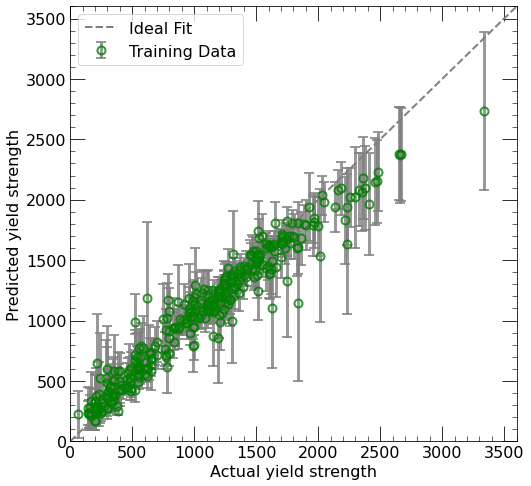

In [32]:
plt.figure(figsize=(8,8))

plt.errorbar(y_train,mean_train,yerr=std_train,mfc='None',mec='green',mew=2,ecolor = 'grey',alpha=0.8, elinewidth= 3,ls = 'none',marker='o',markersize=8,solid_capstyle='projecting', capsize=5,label='Training Data')
plt.xlabel('Actual yield strength',fontsize=16)
plt.ylabel('Predicted yield strength',fontsize=16)
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed',label='Ideal Fit')
plt.legend(fontsize=16)

plt.minorticks_on()
plt.tick_params(labelsize=16)
plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


plt.xlim(0,3600)
plt.ylim(0,3600)
